In [1]:
import functools
import jax
import os
import html

from datetime import datetime
from jax import numpy as jp
jax.config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output, display

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html

import shutil

from src.pods.Pods import train as train_pods
from src.hds.Hds import train as train_hds
from src.env.Pendulum import InvertedPendulum
import pickle




In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

cpu
[CpuDevice(id=0)]


In [3]:
env = InvertedPendulum(target=jp.array([1]))
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

#HTML(html.render(env.sys, [state.pipeline_state]))

In [4]:
ckpt_dir = './tmp/flax_ckpt'

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)  # Remove any existing checkpoints from the last notebook run.

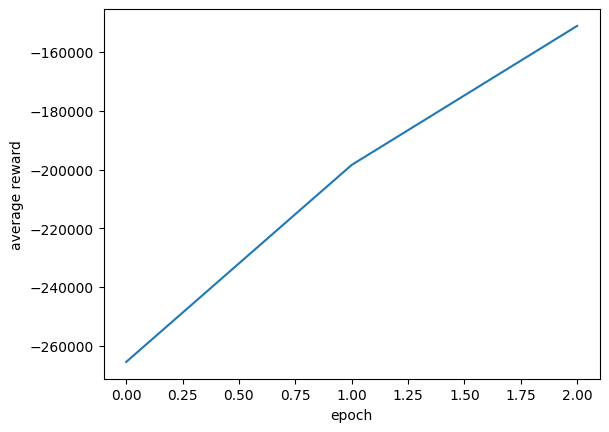

big epoch: 2 small epoch: 0 Loss 6.543827786171553
big epoch: 2 small epoch: 1 Loss 6.481263792008636
big epoch: 2 small epoch: 2 Loss 6.442895667826056
big epoch: 2 small epoch: 3 Loss 6.41599122213991
big epoch: 2 small epoch: 4 Loss 6.396169578757608
big epoch: 2 small epoch: 5 Loss 6.380903973961513
big epoch: 2 small epoch: 6 Loss 6.368988990049416
big epoch: 2 small epoch: 7 Loss 6.359387968639477
big epoch: 2 small epoch: 8 Loss 6.351437668837125
big epoch: 2 small epoch: 9 Loss 6.344754678588392
big epoch: 2 small epoch: 10 Loss 6.339064220283112
big epoch: 2 small epoch: 11 Loss 6.334075725587077
big epoch: 2 small epoch: 12 Loss 6.329773342942461


In [5]:

def progress_f(x_data,y_data,epoch,reward):
    print(reward)
    x_data.append(epoch)
    y_data.append(reward)
    clear_output(wait=True)
    plt.xlabel('epoch')
    plt.ylabel('average reward')
    plt.plot(x_data, y_data)
    plt.show()

# policy = train_hds(env,trajectory_length=100 ,num_samples=100,epochs=10, inner_epochs=20, alpha_a=5e-5, init_learning_rate=1e-4, lambda_policy_update=0.0, progress_fn=progress_f)
policy = train_pods(env,trajectory_length=100 ,num_samples=100,epochs=1000, alpha_a=5e-5, progress_fn=progress_f)

In [ ]:
f = open("reward.txt", "w")
g = open("actions.txt", "w")
inference_fn = policy()
rollout = []
rng = jax.random.PRNGKey(seed=1)
state = env.reset(rng=rng)
reward = []
actions = []
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  #print(state.obs)
  act = inference_fn(state.obs)
  print(act)
  reward.append(state.reward)
  state = env.step(state, act)
  #print(state.reward)
  actions.append(act)

  
print(reward, file=f)
print(actions, file=g)

[0.87408632]
[0.85737867]
[0.7726002]
[0.6146648]
[0.53909334]
[0.73454807]
[0.86677897]
[0.9264808]
[0.94840749]
[0.95416766]
[0.95607071]
[0.95553174]
[0.95140923]
[0.94116897]
[0.91583772]
[0.86200054]
[0.74824493]
[0.52248377]
[0.34030208]
[0.25009819]
[0.20107388]
[0.18014328]
[0.20748612]
[0.24081274]
[0.26766929]
[0.28151944]
[0.27866913]
[0.26172258]
[0.23077909]
[0.19104175]
[0.14412734]
[0.09758355]
[0.05256094]
[0.01254041]
[-0.01991834]
[-0.00072469]
[0.02959049]
[0.0500415]
[0.06225503]
[0.06739749]
[0.0636472]
[0.0632583]
[0.05948649]
[0.04293277]
[0.03237917]
[0.03105061]
[0.03481186]
[0.04250551]
[0.04645819]
[0.03502971]
[0.02237256]
[0.00901844]
[-0.00536644]
[-0.01772853]
[-0.02718865]
[-0.03515638]
[-0.03953618]
[-0.04206272]
[-0.04326585]
[-0.04736944]
[-0.0518959]
[-0.06532881]
[-0.08660791]
[-0.09583617]
[-0.10364219]
[-0.11034192]
[-0.11451115]
[-0.11777253]
[-0.12059797]
[-0.12276588]
[-0.12826936]
[-0.14134875]
[-0.15818631]
[-0.17254941]
[-0.1863359]
[-0.2005

In [ ]:

yes=html.render(env.sys.replace(dt=env.dt), rollout)
with open("data.html", "w") as file:
    file.write(yes)